In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import fppnpx as fn
from fppnpx.ChannelSignal import ChannelSignal
from fppnpx.FPPGLM import FPPGLM
from fppnpx.signalfuncs import load_signal, gen_all_channel_signals
from wavemapnpx.WaveMAPClassifier import WaveMAPClassifier

from plottools import WAVEMAP_PAL, ml_map, cmap

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

/opt/miniconda3/envs/wavemapspec/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
apath = "/Users/mateouma/Downloads/monkey datasets/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0_t0.exported.imec0.ap-001.bin"
cpath = "/Users/mateouma/Downloads/monkey datasets/cluster_info_task.tsv"
wpath = "/Users/mateouma/Downloads/monkey datasets/20230630_DLPFCwaveforms.mat"

fs = 30000
time_window = [100,123] # [204,209] # 

Nt = int(fs * (time_window[1] - time_window[0]))

signal_dataset = load_signal(appath=apath, time_window=time_window, fs=fs, cipath=cpath, wfpath=wpath)
channel_signals = gen_all_channel_signals(signal_dataset)

Generated 112 channel signals.


In [120]:
from numpy.lib.stride_tricks import sliding_window_view


def calculate_unit_firing_rate(chanID, unitID, fs, window_size=0.5, step_size=0.5):
    twindow = int(window_size * fs)
    tstep = int(step_size * fs)

    unit_spk_train = np.zeros(Nt)
    unit_spk_train[channel_signals[chanID].spike_times[unitID].astype(int)] = 1
    unit_spk_train_windowed = sliding_window_view(unit_spk_train, window_shape=twindow)
    unit_firing_rate = unit_spk_train_windowed[::tstep].sum(axis=1) / window_size

    return unit_firing_rate

def calculate_ts_firing_rate(spk_train, fs, window_size=0.5, step_size=0.5):
    twindow = int(window_size * fs)
    tstep = int(step_size * fs)

    spk_train_windowed = sliding_window_view(spk_train, window_shape=twindow)
    firing_rate = spk_train_windowed[::tstep].sum(axis=1) / window_size

    return firing_rate

def calculate_firing_rates(spike_trains, fs, window_size=0.5, step_size=0.5, cluster_labels=None):
    cluster_firing_rates = []
    cluster_mean_firing_rates = []
    cluster_ste_firing_rates = []

    twindow = int(window_size * fs)
    tstep = int(step_size * fs)
    
    if cluster_labels is not None:
        cluster_lab_dir = np.unique(cluster_labels)
        N_clust = cluster_lab_dir.size

        cluster_mask = [np.where(cluster_labels == cl)[0] for cl in cluster_lab_dir]
    else:
        N_clust = 1
        cluster_mask = [np.arange(spike_trains.shape[1])]

    for cl in range(N_clust):
        cluster_spk_trains = spike_trains[:,cluster_mask[cl]]

        windowed_spk_trains = sliding_window_view(cluster_spk_trains, window_shape=twindow, axis=0)
        firing_rates = windowed_spk_trains[::tstep].sum(axis=2) / window_size

        cluster_firing_rates.append(firing_rates.sum(axis=1))
        cluster_mean_firing_rates.append(firing_rates.mean(axis=1))
        cluster_ste_firing_rates.append(firing_rates.std(axis=1) / np.sqrt(firing_rates.shape[1]))

    if cluster_labels is None:
        cluster_firing_rates = cluster_firing_rates[0]
        cluster_mean_firing_rates = cluster_mean_firing_rates[0]
        cluster_ste_firing_rates = cluster_ste_firing_rates[0]

    return cluster_firing_rates, cluster_mean_firing_rates, cluster_ste_firing_rates

In [12]:
u374fr = calculate_unit_firing_rate('ch205', 374, fs)
u375fr = calculate_unit_firing_rate('ch205', 375, fs)
u378fr = calculate_unit_firing_rate('ch208', 378, fs)
u379fr = calculate_unit_firing_rate('ch208', 379, fs)
u380fr = calculate_unit_firing_rate('ch209', 380, fs)
u383fr = calculate_unit_firing_rate('ch212', 383, fs)

In [36]:
fr_time = np.arange(time_window[0], time_window[1], 0.5)

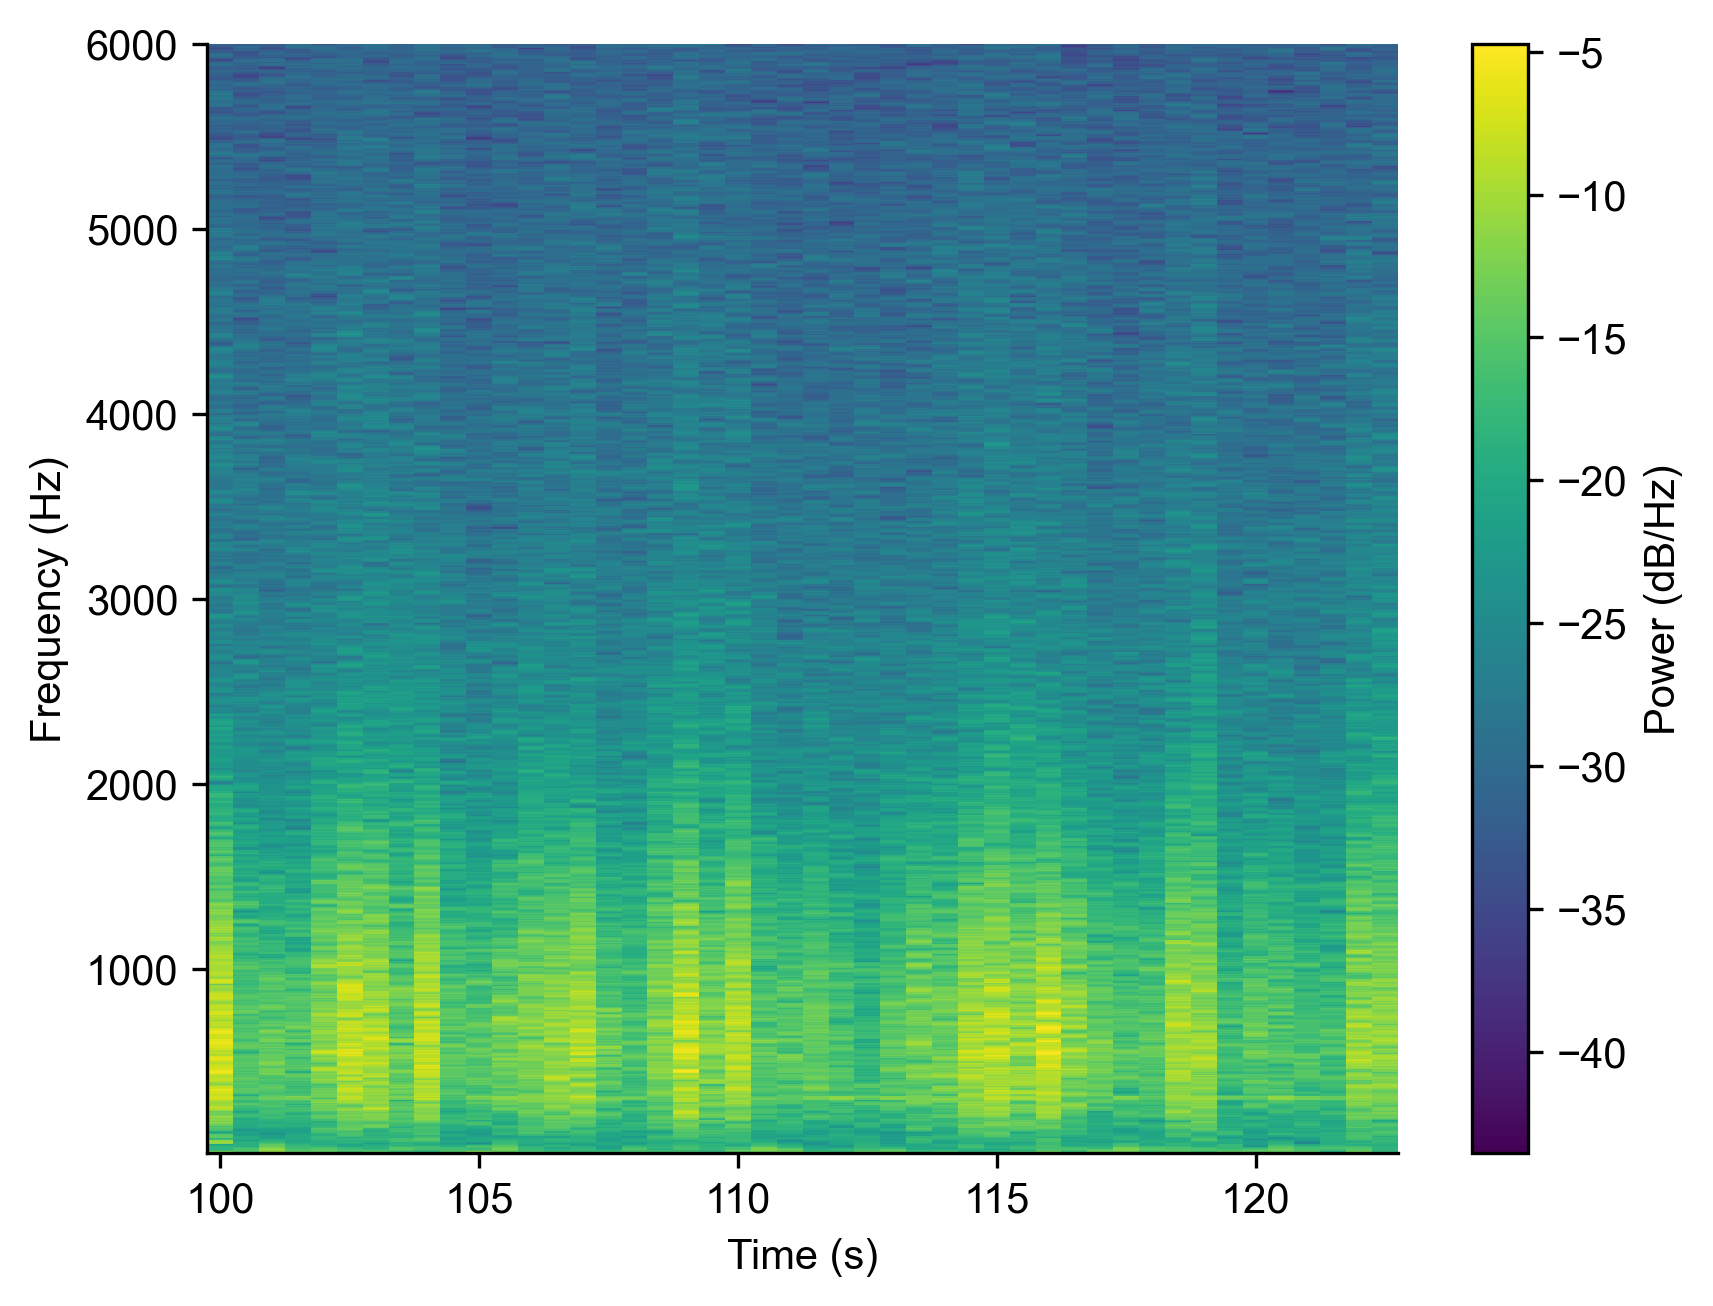

In [42]:
fn.spectrafuncs.plot_spectrogram(channel_signals['ch208'].time_series, fs, time_halfbandwidth_product=5.75, window_duration=0.5, window_step=0.5, start_time=time_window[0], ymin=1, ymax=6000)

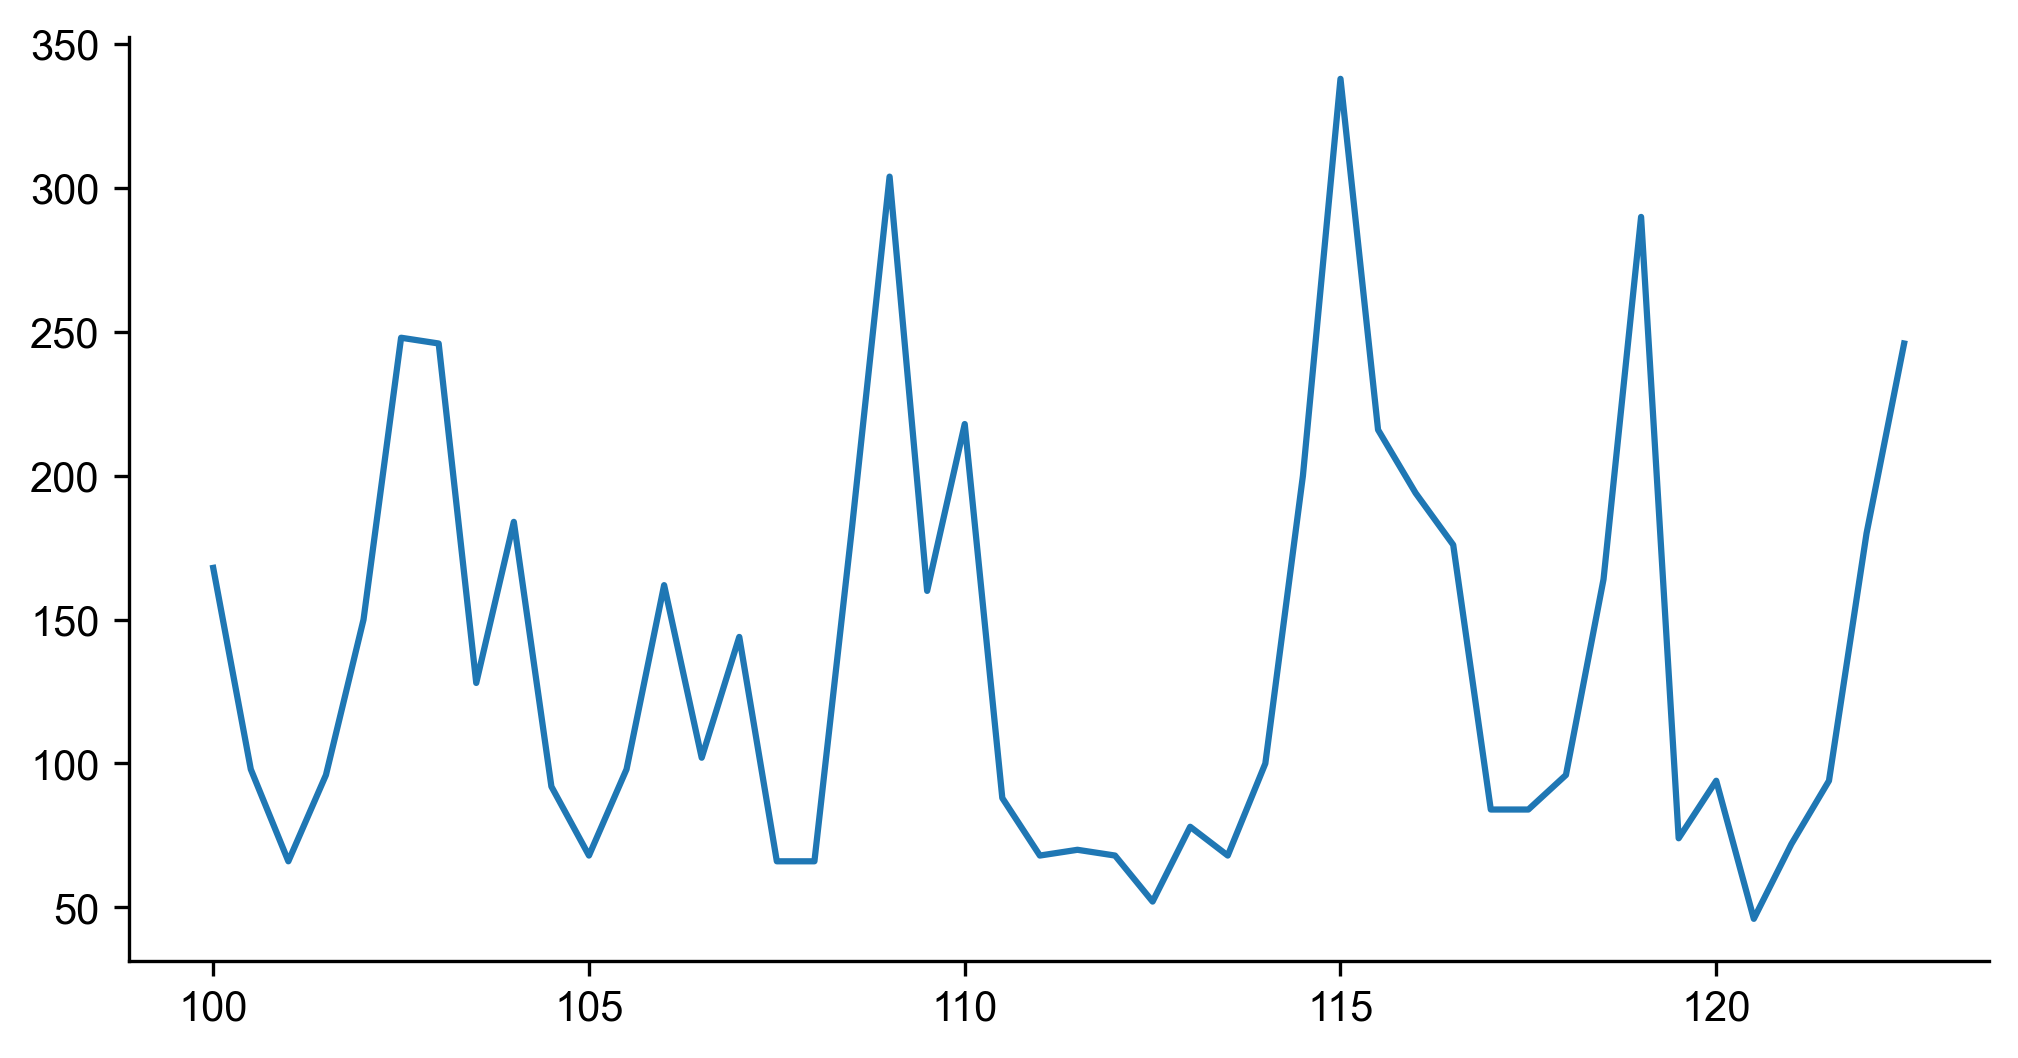

In [ ]:
plt.figure(figsize=(8,4), dpi=300)
plt.plot(fr_time, np.sum([u374fr, u375fr, u378fr, u379fr, u380fr, u383fr], axis=0))

In [19]:
u286fr = calculate_unit_firing_rate('ch162', 286, fs)
u287fr = calculate_unit_firing_rate('ch160', 287, fs)
u291fr = calculate_unit_firing_rate('ch160', 291, fs)
u292fr = calculate_unit_firing_rate('ch160', 292, fs)
u296fr = calculate_unit_firing_rate('ch163', 296, fs)
u298fr = calculate_unit_firing_rate('ch166', 298, fs)

In [29]:
Nt = channel_signals["ch13"].time_axis.size # number of time points
Nu = signal_dataset['units'].size # number of units

spike_trains_unsorted = np.zeros((Nt, Nu))
units_unsorted = []

u_idx = 0
for ch,ch_sig in channel_signals.items():
    for u, spktimes in ch_sig.spike_times.items():
        spike_trains_unsorted[spktimes.astype(int),u_idx] = 1
        units_unsorted.append(u)
        u_idx += 1

spike_trains = spike_trains_unsorted[:,np.argsort(units_unsorted)]

In [31]:
pop_frs,mean_pop_frs,__ = calculate_firing_rates(spike_trains, fs)

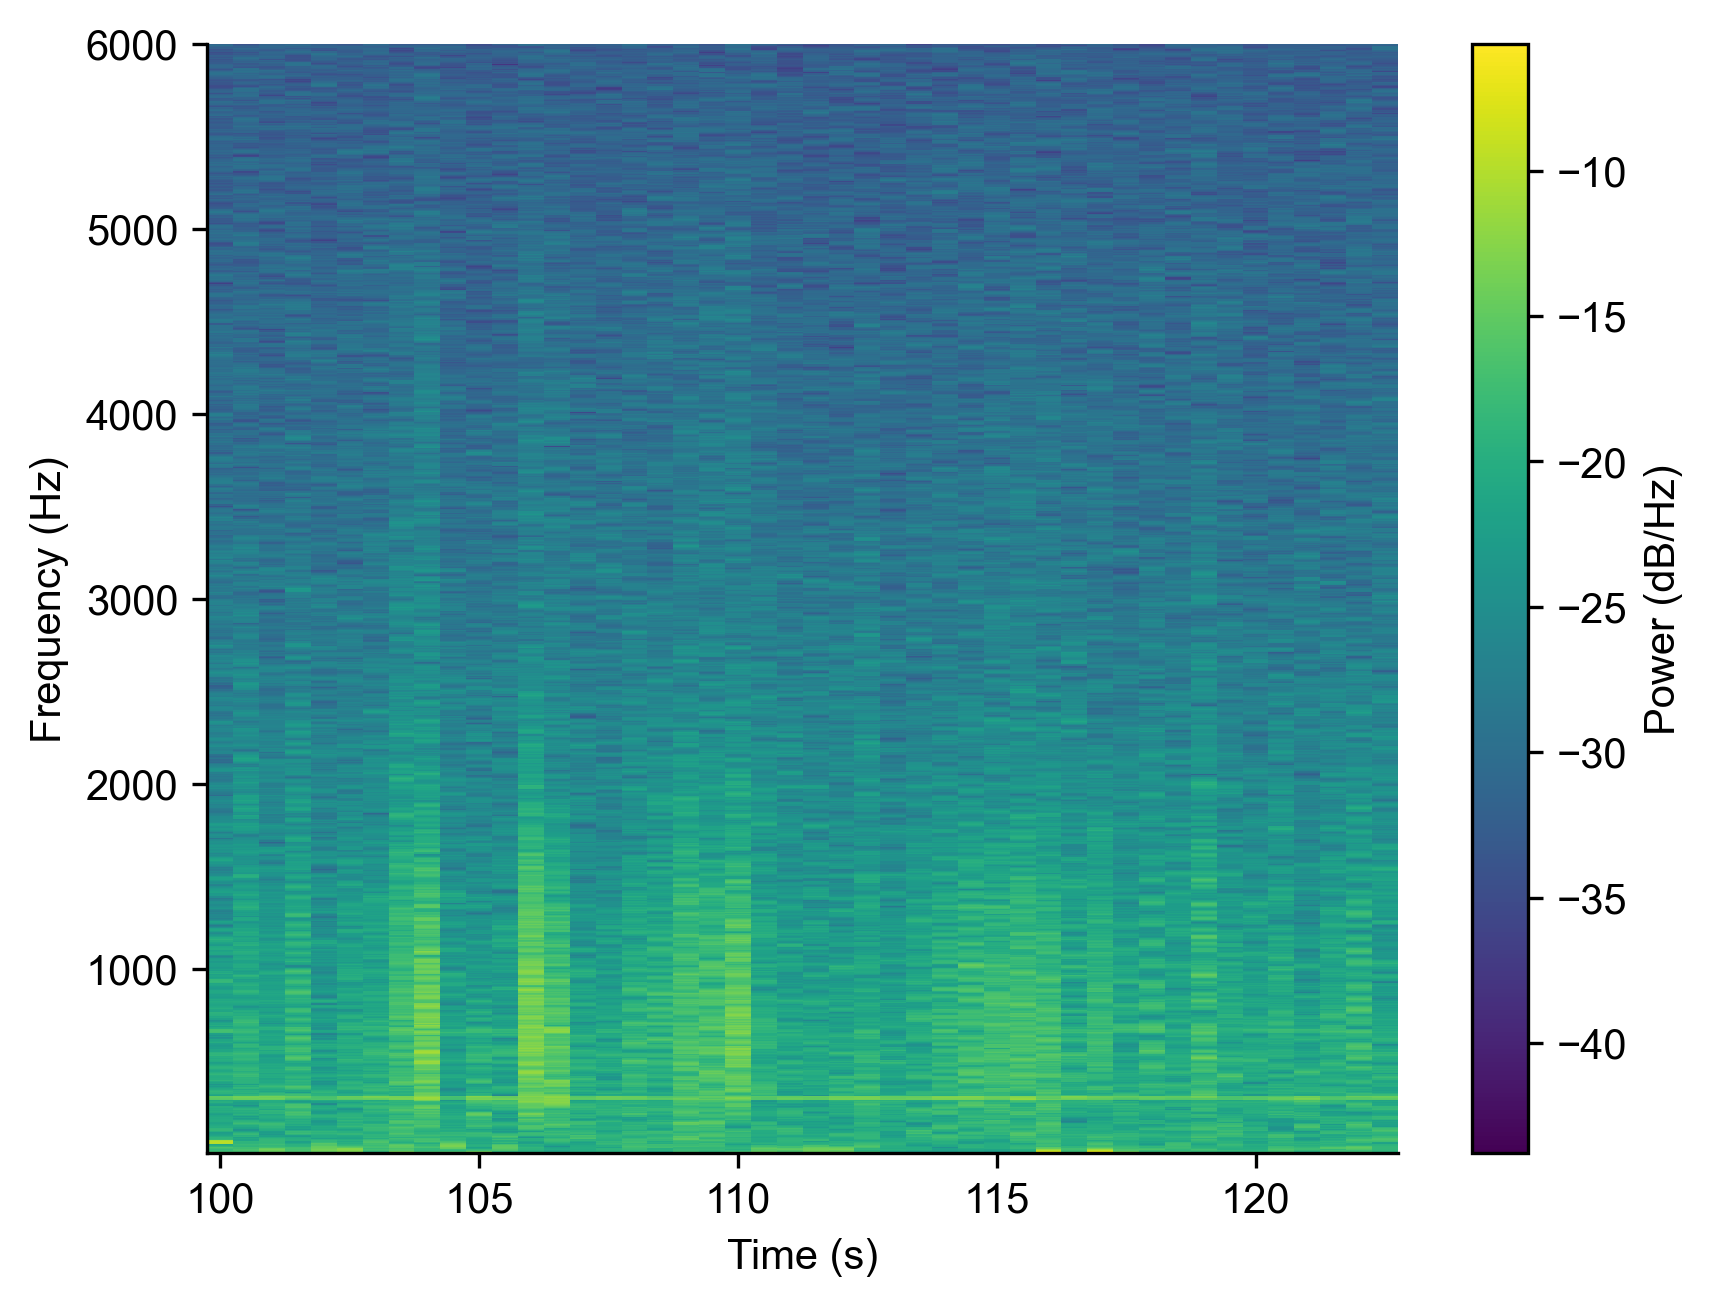

In [43]:
fn.spectrafuncs.plot_spectrogram(channel_signals['ch163'].time_series, fs, time_halfbandwidth_product=5.75, window_duration=0.5, window_step=0.5, start_time=time_window[0], ymin=1, ymax=6000)

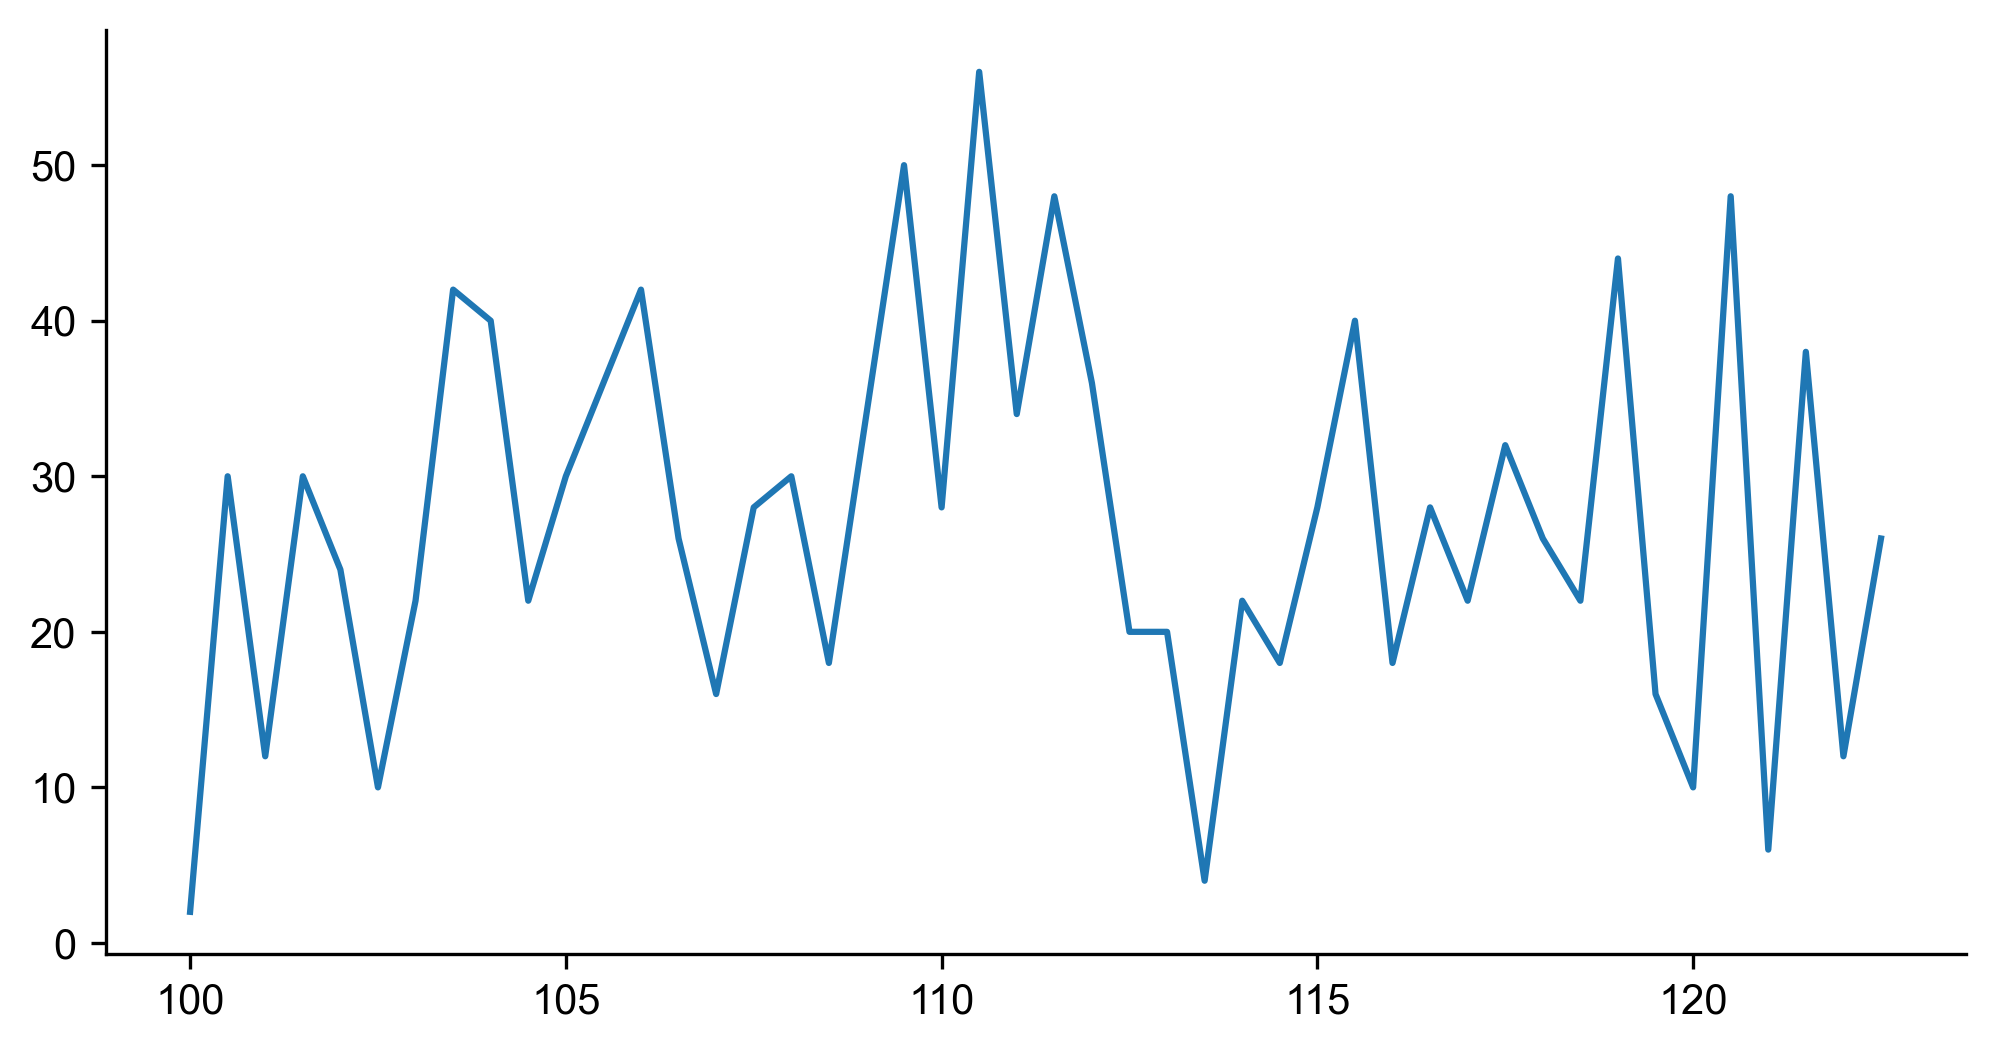

In [50]:
plt.figure(figsize=(8,4), dpi=300)
plt.plot(fr_time, np.sum([u286fr, u287fr, u291fr, u292fr, u296fr, u298fr], axis=0))
# plt.plot(fr_time, u296fr)

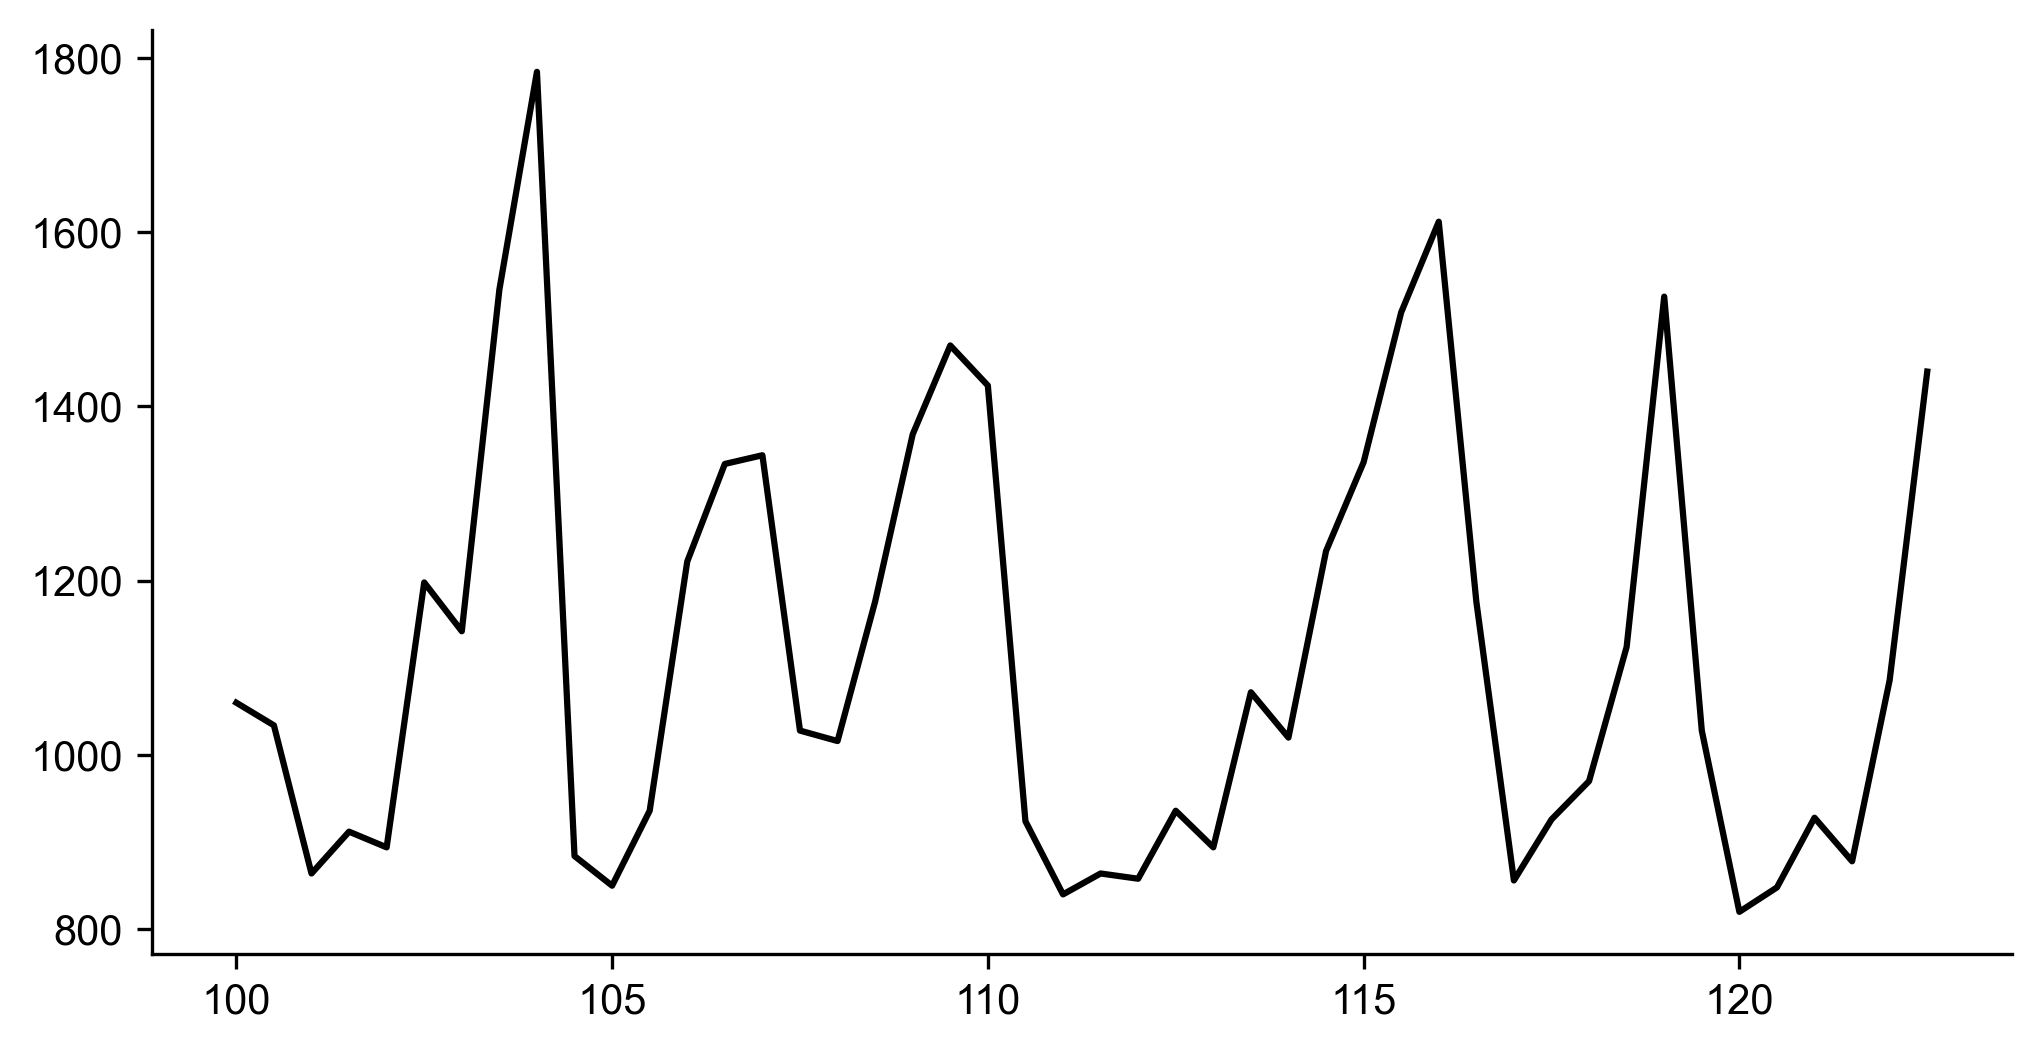

In [35]:
plt.figure(figsize=(8,4), dpi=300)
plt.plot(fr_time, pop_frs, color='k')

In [55]:
u378_instances,u378_filters,theor_freqs = channel_signals['ch208'].generate_unit_filters(selected_unit=378)
u379_instances,u379_filters,_ = channel_signals['ch208'].generate_unit_filters(selected_unit=379)
u374_instances,u374_filters,_ = channel_signals['ch205'].generate_unit_filters(selected_unit=374)
u375_instances,u375_filters,_ = channel_signals['ch205'].generate_unit_filters(selected_unit=375)
u380_instances,u380_filters,_ = channel_signals['ch209'].generate_unit_filters(selected_unit=380)
u383_instances,u383_filters,_ = channel_signals['ch212'].generate_unit_filters(selected_unit=383)

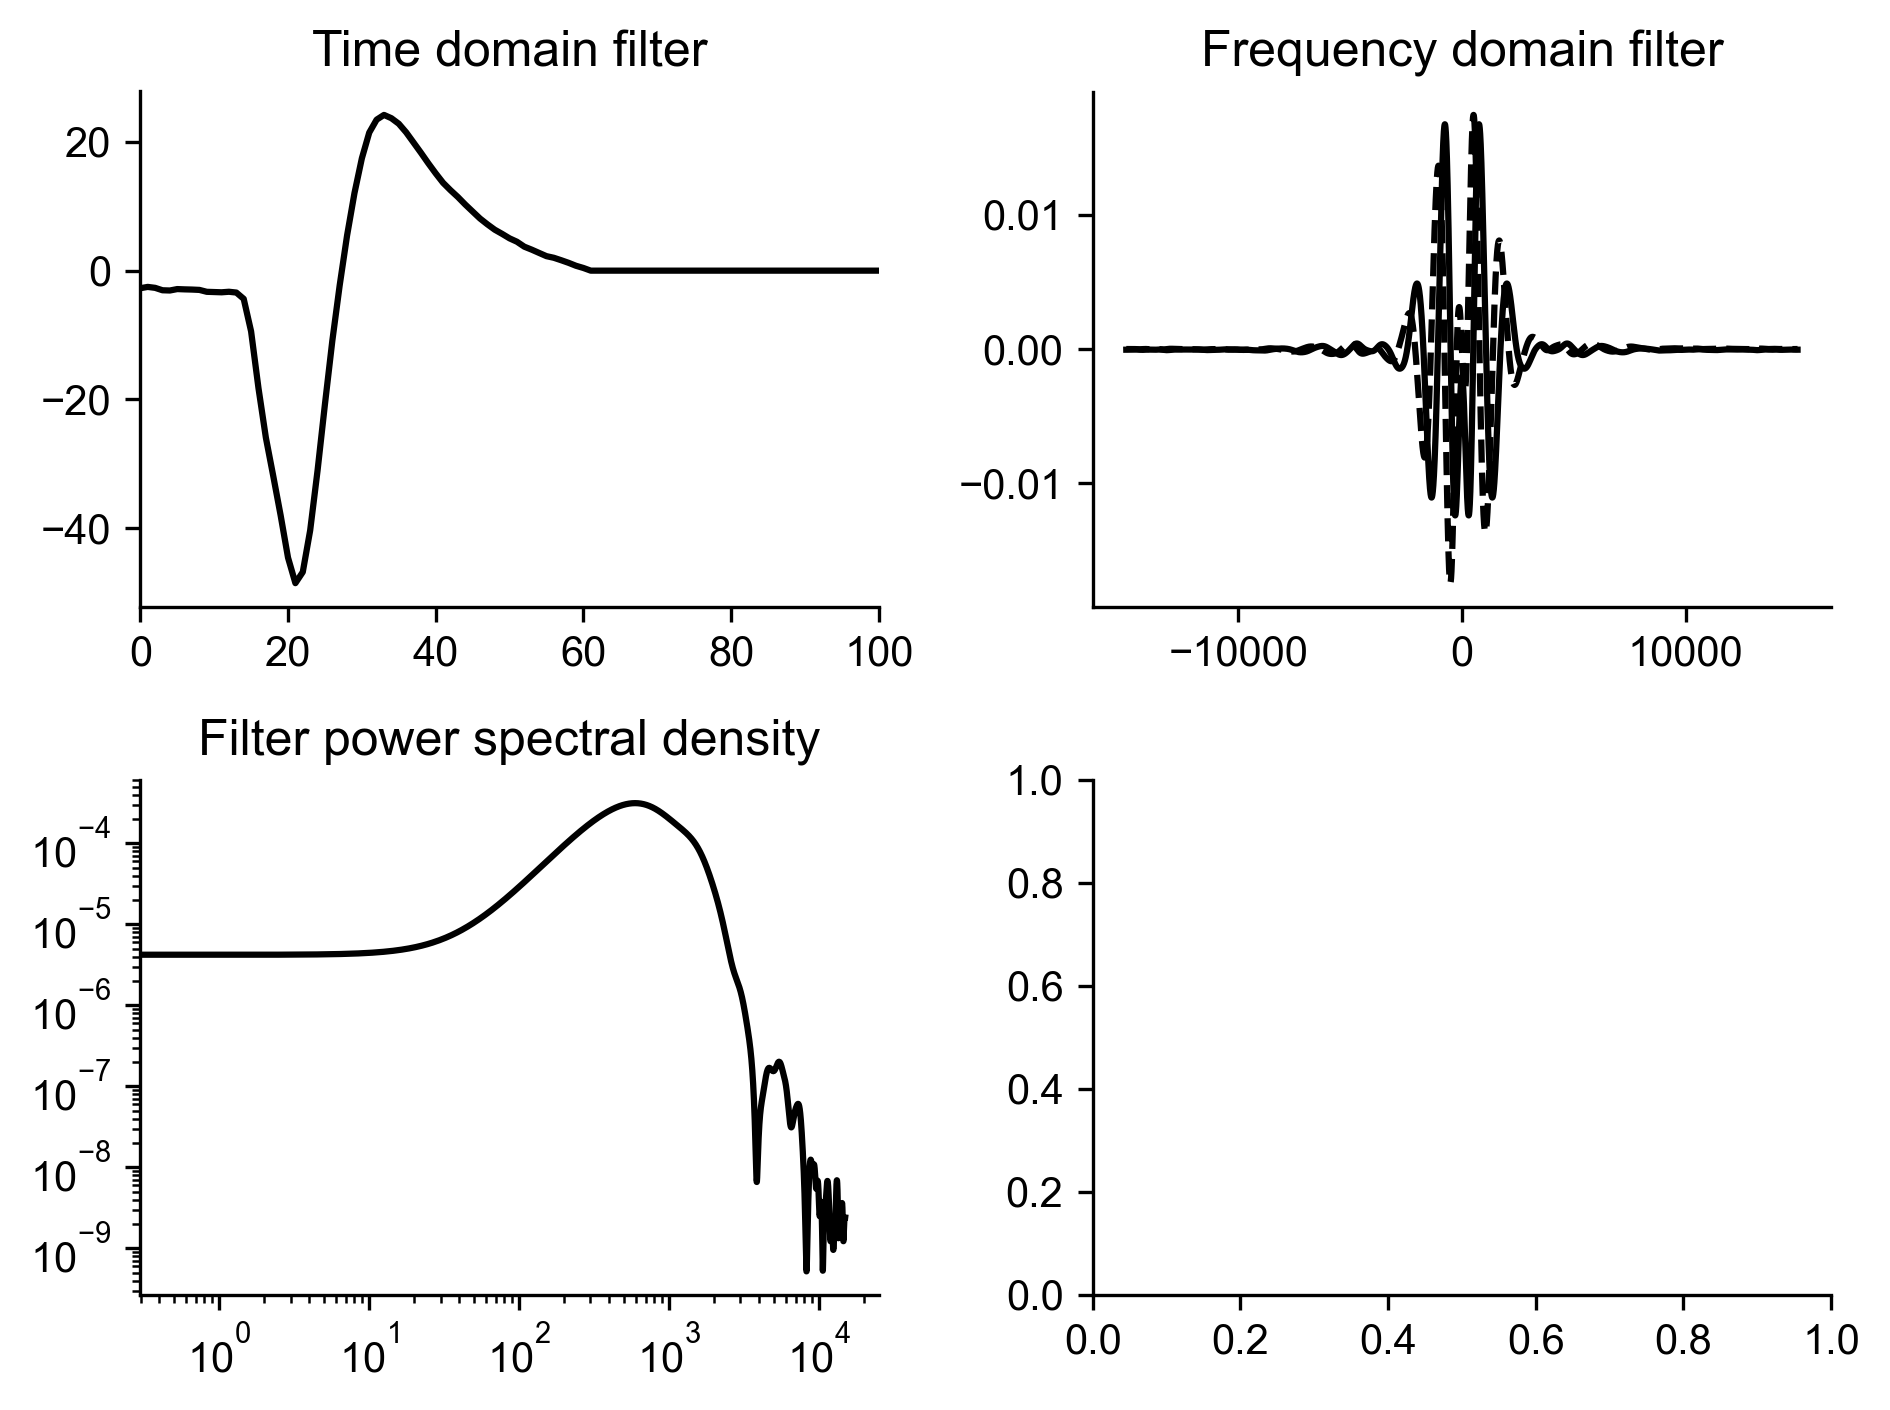

In [59]:
fn.filterfuncs.plot_filters(u379_filters['average_waveform']['time_filter'],
                            u379_filters['average_waveform']['freq_filter'],
                            u379_filters['average_waveform']['filter_psd'], theor_freqs)

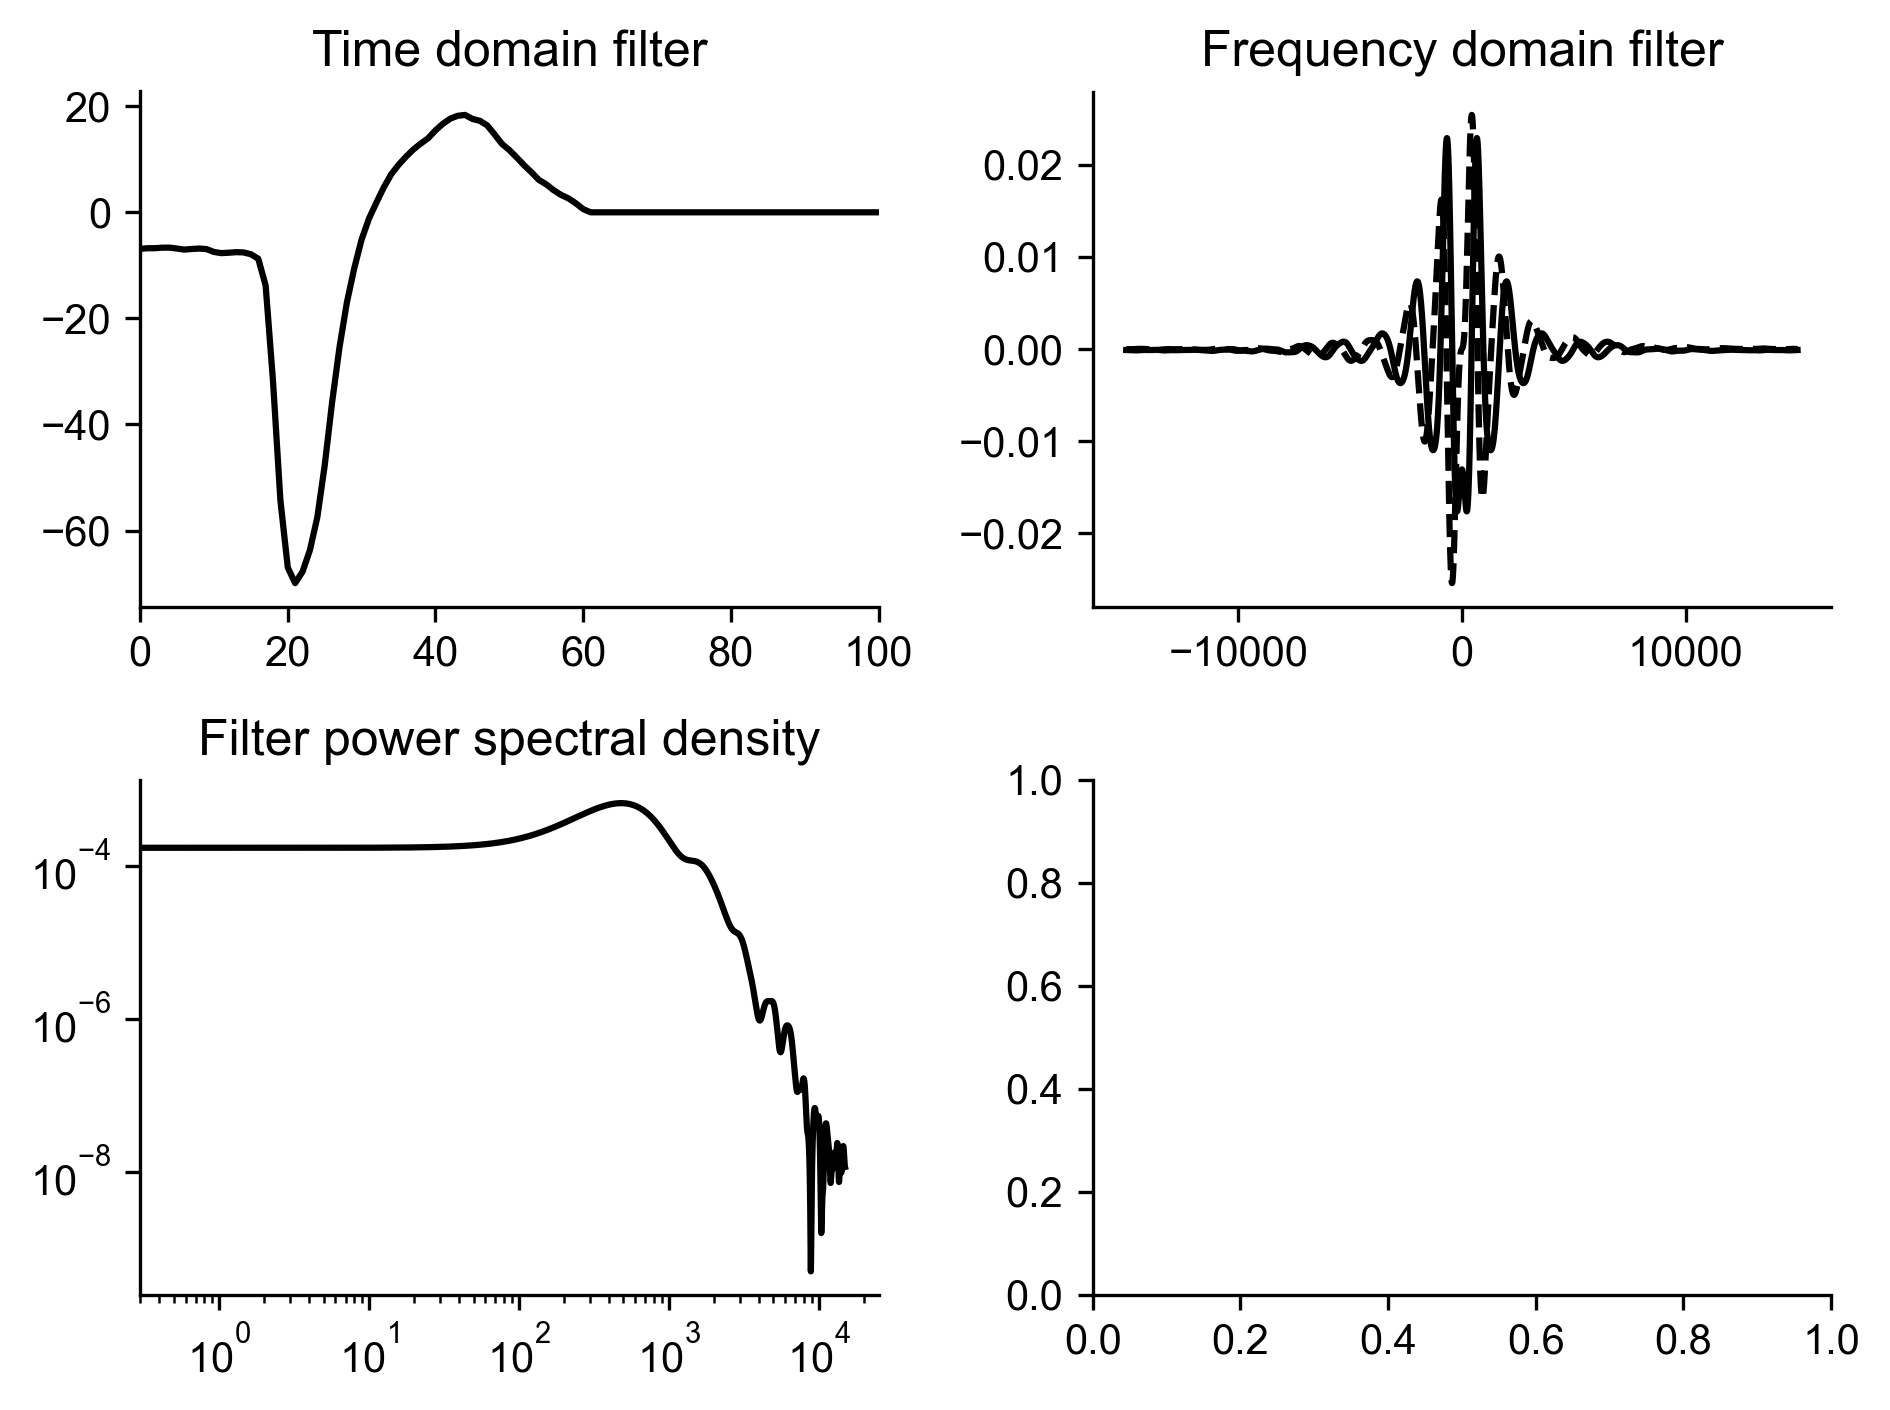

In [58]:
fn.filterfuncs.plot_filters(u383_filters['average_waveform']['time_filter'],
                            u383_filters['average_waveform']['freq_filter'],
                            u383_filters['average_waveform']['filter_psd'], theor_freqs)

In [100]:
individual_spk_arr = np.zeros((channel_signals['ch208'].spike_times[379].size, fs*(time_window[1]-time_window[0])))

nspks = len(u379_instances['waveforms'])

# this is a pretty inefficient way, it would just be easier to index the signal around each spike time
# but i already wrote this once i realized
for i,spk_time in enumerate(channel_signals['ch208'].spike_times[379].astype(int)):
    if spk_time < 20:
        continue

    if i >= nspks:
        break

    individual_spk_arr[i,spk_time] = 1

    exact_spk_instance = np.convolve(individual_spk_arr[i], u379_instances['waveforms'][i])

    individual_spk_arr[i] = exact_spk_instance[20:-41]

exact_spks = np.sum(individual_spk_arr, axis=0)

In [101]:
individual_spk_arr2 = np.zeros((channel_signals['ch212'].spike_times[383].size, fs*(time_window[1]-time_window[0])))

nspks = len(u383_instances['waveforms'])

# this is a pretty inefficient way, it would just be easier to index the signal around each spike time
# but i already wrote this once i realized
for i,spk_time in enumerate(channel_signals['ch212'].spike_times[383].astype(int)):
    if spk_time < 20:
        continue

    if i >= nspks:
        break

    individual_spk_arr2[i,spk_time] = 1

    exact_spk_instance = np.convolve(individual_spk_arr2[i], u383_instances['waveforms'][i])

    individual_spk_arr2[i] = exact_spk_instance[20:-41]

exact_spks2 = np.sum(individual_spk_arr2, axis=0)

In [102]:
ts_signal = exact_spks + exact_spks2

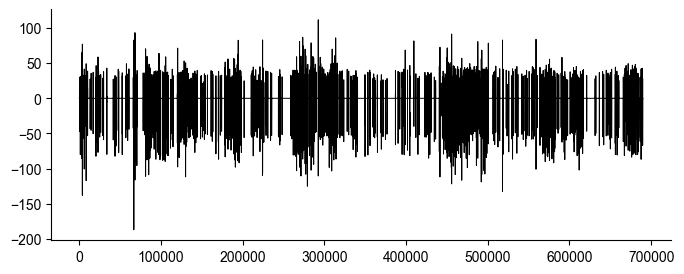

In [175]:
plt.figure(figsize=(8,3))
plt.plot(ts_signal, color='k', linewidth=0.7)

In [110]:
from fppnpx.FPPSSM import FPPSSM

Model instantiated


In [107]:
ssm_filters = [u379_filters['waveform_instance']['filter_psd'],
               u383_filters['average_waveform']['filter_psd']]

In [111]:
fppssm_full = FPPSSM(ts_signal, channel_signals['ch208'].time_axis, fs)

In [112]:
fppssm_full.fit_mv(ssm_filters, theor_freqs, 20)

Instantiating model...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_1, alpha_2, sigma, d_0, d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9, d_10, d_11, d_12, d_13, d_14, d_15, d_16, d_17, d_18, d_19, d_20, d_21, d_22, d_23, d_24, d_25, d_26, d_27, d_28, d_29, d_30, d_31, d_32, d_33, d_34, d_35, d_36, d_37, d_38, d_39, d_40, d_41, d_42, d_43, d_44, d_45]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1182 seconds.


In [113]:
rate_preds = []

for i in range(46):
    rate_preds.append(fppssm_full.trace_back.posterior.data_vars[f'd_{i}'].mean(axis=(0,1)).values)

rate_preds = np.array(rate_preds)

In [114]:
rate_preds.shape

(46, 2)

In [118]:
u1_spktrain = np.zeros(Nt)

for i,spk_time in enumerate(channel_signals['ch208'].spike_times[379].astype(int)):
    u1_spktrain[spk_time] = 1

u2_spktrain = np.zeros(Nt)

for i,spk_time in enumerate(channel_signals['ch212'].spike_times[383].astype(int)):
    u2_spktrain[spk_time] = 1

In [121]:
u1_fr = calculate_ts_firing_rate(u1_spktrain, fs)
u2_fr = calculate_ts_firing_rate(u2_spktrain, fs)

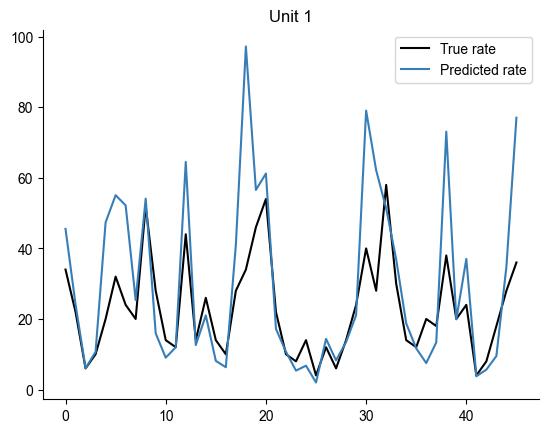

In [178]:
plt.plot(u1_fr, color='k', label='True rate')
plt.plot(rate_preds[:,0] + 20, color=cmap(1), label='Predicted rate')
plt.title("Unit 1")
plt.legend()


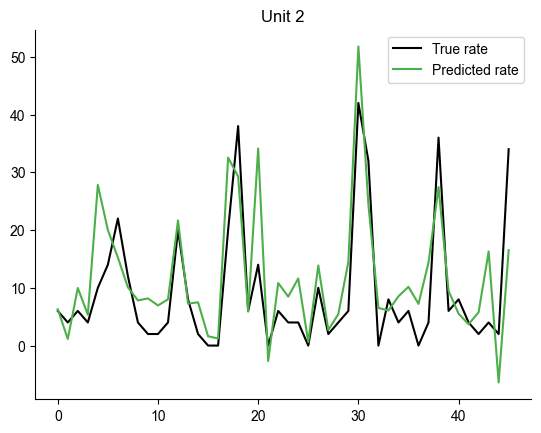

In [179]:
plt.plot(u2_fr, color='k', label='True rate')
plt.plot(rate_preds[:,1] + 20, color=cmap(2), label='Predicted rate')
plt.title("Unit 2")
plt.legend()


In [167]:
rate_preds_adj = rate_preds + 20
pred_spec = rate_preds_adj @ fppssm_full.S_f_interp_list

In [134]:
obs_spec = fn.spectrafuncs.multitaper_spectrogram(ts_signal, fs, time_halfbandwidth_product=5.75, window_duration=0.5, window_step=0.5, start_time=time_window[0])

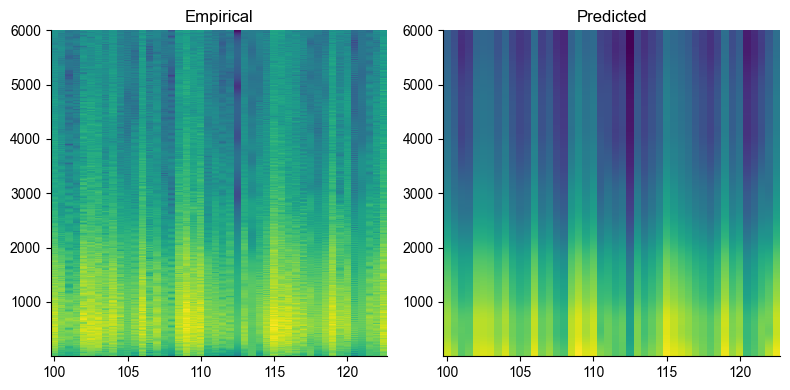

In [177]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
im = ax[0].pcolormesh(
    obs_spec.time,
    obs_spec.frequencies,
    10 * np.log10(obs_spec.power().squeeze().T),
    cmap="viridis",
    shading="auto",
)
ax[0].set_ylim(1,6000)
ax[0].set_title("Empirical")

im2 = ax[1].pcolormesh(
    obs_spec.time,
    fppssm_full.spectrogram_trunc_freqs,
    10 * np.log10(pred_spec.T),
    cmap='viridis',
    shading='auto'
)
ax[1].set_ylim(1,6000)
ax[1].set_title("Predicted")

fig.tight_layout()
